In [1]:
import numpy as np
import matplotlib

In [2]:
import dolfyn.adv.api as avm
import dolfyn.adv.turbulence as turb

In [3]:
matplotlib.use("Qt5Agg")
from PyQt5 import QtCore
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget

In [4]:
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib.ticker as mtick
import os.path

In [5]:
%%time
import urllib2

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.9 µs


In [6]:
fname = '/Users/lillie/turbulence_data/raw_data/TTM_NREL03_May2015'
body2head_vec = np.array([9.75, 2, -5.75]) * 0.0254
body2head_rotmat = np.array([[0, 0, -1], [0, -1, 0], [-1, 0, 0]])
accel_filter = 0.1
load_vec = True

In [7]:
%%time
#If the file exists...

#....as an '.h5' file, read it
if os.path.isfile(fname + '.h5'):
    dat_raw = avm.load(fname + '.h5')
#....as a '.VEC' file, save it as an '.h5' and then read it using dolfyn library
elif os.path.isfile(fname + ',VEC'):
    dat_raw = avm.read_nortek(fname + '.VEC')
    dat_raw.save(fname + '.h5')  

# If the file does not exist as either a '.VEC' or '.h5', download it from the internet, save it as a '.h5' file and read it
else:
    file = 'TTM_NREL03_May2015.VEC'
    url = 'https://mhkdr.openei.org/files/51/TTM_NREL03_May2015.VEC'
    response = urllib2.urlopen(url)
    with open(file, 'wb') as f: 
        f.write(response.read())
    dat_raw = avm.read_nortek(data)
    dat_raw.save(fname + '.h5')   

CPU times: user 1.42 s, sys: 223 ms, total: 1.65 s
Wall time: 3.17 s


In [8]:
x_start = .00835 + 7.3572944e5
x_end = .304 + 7.35731e5
t_range = [x_start, x_end]
t_range

[735729.44835, 735731.304]

In [9]:
t_range_inds = (t_range[0] < dat_raw.mpltime) & (dat_raw.mpltime < t_range[1])
dat_crop = dat_raw.subset(t_range_inds)
dat_crop.props['body2head_vec'] = body2head_vec
dat_crop.props['body2head_rotmat'] = body2head_rotmat

In [10]:
%%time
t_range_inds = (t_range[0] < dat_raw.mpltime) & (dat_raw.mpltime < t_range[1])
dat = dat_raw.subset(t_range_inds)
dat.props['body2head_vec'] = body2head_vec
dat.props['body2head_rotmat'] = body2head_rotmat

# Then clean the file using the Goring+Nikora method:
avm.clean.GN2002(dat)
dat_cln = dat.copy()

CPU times: user 49.6 s, sys: 4.33 s, total: 54 s
Wall time: 53.5 s


In [11]:
%%time
avm.motion.correct_motion(dat_crop, accel_filter)

# Rotate the uncorrected data into the earth frame,
# for comparison to motion correction:
avm.rotate.inst2earth(dat_cln)

# ax.plot(dat.mpltime, dat.u, 'b-')

# Then rotate it into a 'principal axes frame':
avm.rotate.earth2principal(dat_crop)
avm.rotate.earth2principal(dat_cln)


CPU times: user 3.68 s, sys: 719 ms, total: 4.4 s
Wall time: 4.32 s


<IPython.core.display.Javascript object>


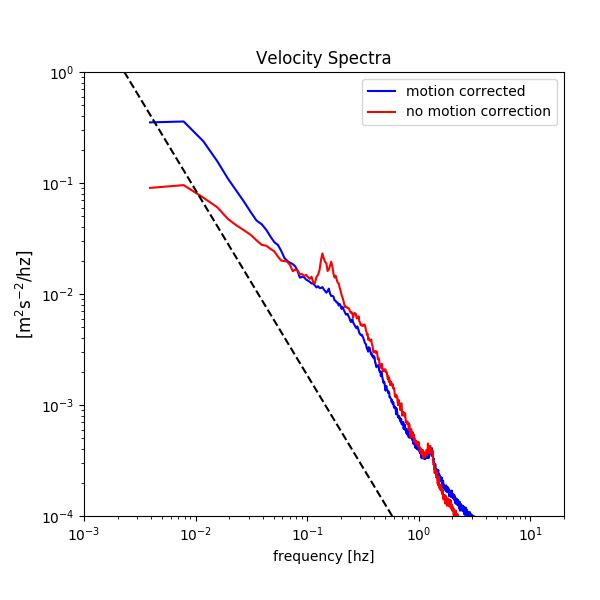

CPU times: user 4.03 s, sys: 460 ms, total: 4.49 s
Wall time: 4.66 s


In [12]:
%%time
%matplotlib nbagg
# Average the data and compute turbulence statistics
dat_bin = avm.calc_turbulence(dat, n_bin=19200,
                                n_fft=4096)
dat_cln_bin = avm.calc_turbulence(dat_cln, n_bin=19200,
                                    n_fft=4096)

fig = plt.figure(2, figsize=[6, 6])
fig.clf()
ax = fig.add_axes([.14, .14, .8, .74])

ax.loglog(dat_bin.freq, dat_bin.Suu_hz.mean(0),
            'b-', label='motion corrected')
ax.loglog(dat_cln_bin.freq, dat_cln_bin.Suu_hz.mean(0),
            'r-', label='no motion correction')

ax.set_xlim([1e-3, 20])
ax.set_ylim([1e-4, 1])
ax.set_xlabel('frequency [hz]')
ax.set_ylabel('$\mathrm{[m^2s^{-2}/hz]}$', size='large')

f_tmp = np.logspace(-3, 1)
ax.plot(f_tmp, 4e-5 * f_tmp ** (-5. / 3), 'k--')

ax.set_title('Velocity Spectra')
ax.legend()

plt.show()

First, Homebrew must be installed in order to install a Fortran Compiler, which is necessary to install PyTurbSim. 

In [13]:
!/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"

==> This script will install:
/usr/local/bin/brew
/usr/local/share/doc/homebrew
/usr/local/share/man/man1/brew.1
/usr/local/share/zsh/site-functions/_brew
/usr/local/etc/bash_completion.d/brew
/usr/local/Homebrew

Press RETURN to continue or any other key to abort


In [15]:
!brew install gcc

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
uftp
==> Updated Formulae
akka                       gradle                     mitmproxy
aws-sdk-cpp                gst-editing-services       mongo-orchestration
awscli                     gst-libav                  node
azure-cli                  gst-plugins-bad            node-build
bee                        gst-plugins-base           osc
casperjs                   gst-plugins-good           parallel
charm                      gst-plugins-ugly           putty
cheops                     gst-python                 rust
cjdns                      gst-rtsp-server            sops
curl                       gst-validate               terragrunt
docker-compose             gstreamer                  tile38
docker-compose-completion  jump                       xonsh
geoserver                  kerl                       youtube-dl
gitlab-ci-multi-runner     libarchive                 zstd
gnome-a

Next, install PyTurbSim using pip

In [16]:
!pip install PyTurbSim

Next, we must import the PyTurbSim package as pyts. 

In [17]:
import pyts.specModels
import pyts.api as pyts
import pyts.plot.api as pt

In [18]:
from pyts.specModels.hydro import specModelBase, np, specObj, ts_float

### Define some variables:

In [19]:
refht = 10.
ustar = 0.03
Uref = 3

### Initialize a 'run' object:

In [20]:
tsr = pyts.tsrun()

### Define the grid:

In [21]:
tsr.grid = pyts.tsGrid(
    center=refht, ny=5, nz=5, height=5, width=9, time_sec=1000, dt=0.5)


### Define a mean 'profile model' and assign it to the run object:

In [22]:
prof_model = pyts.profModels.h2l(Uref, refht, ustar)

In [23]:
tsr.profModel = prof_model

### Define and assign a 'spectral model', 'coherence model', and 'stress model' to the run object:

In [24]:
tsr.specModel = pyts.specModels.tidal(ustar, refht)
tsr.cohere = pyts.cohereModels.nwtc()
tsr.stress = pyts.stressModels.tidal(ustar, refht)

### 'call' the run oject to produce the TurbSim output:

In [25]:
turbsim_output = tsr()
turbsim_output

<TurbSim data object:
2000 0.50s-timesteps, 5.00x9.00m (5x5) z-y grid (hubheight=10.00m).>

### Create a ‘PyTurbSim summary plotting figure’:


<IPython.core.display.Javascript object>


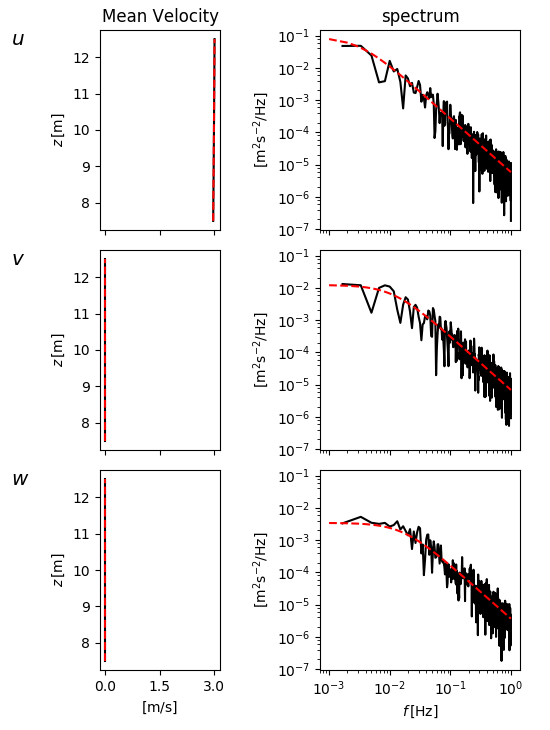

/Users/lillie/anaconda/lib/python2.7/site-packages/pyts/plot/superaxes.py:753: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  self.ax[iv, ih].hold(True)


In [26]:
fig = pt.summfig()

### Plot PyTurbSim output:

In [27]:
fig.plot(turbsim_output, color='k')

In [28]:
fig.plot(tsr, color='r', linestyle='--')

In [29]:
fig.finalize()

Now trying it with our data.......